**Для домашней работы я решил взять свой датасет**

Я участвую в проекте, организованном студентами GB. Цель - получть в портфолио опыт командной работы, чтобы более выгодно выглядеть на собеседованиях.

Суть проекта в следующем - разработать сервис для планирования путешествий. Пользователь вводит начальную и конечную точку, дату поездки, и сервис по ходу маршрута предлагает заехать в различные города и посетить различные мероприятия и достопримечательности.

В качестве основного источника данных сейчас решили взять vk, так как он предоставляет открытое api  с большим количеством запросов в сутки (5000). Я спарсил данные с большого количества групп, посвященных городам и путешествиям. Теперь как раз нужно провести тематический анализ текстов.

Основные цели тематического анализа для нас:
- вообще посмотреть, что за данные у нас есть
- помощь в разметке датасета: если удастся выделить темы с достопримечательностями и мероприятиями, будет очень здорово. Далее надо будет только пробежаться глазами и убрать лишние посты. Потом обучить на размеченных данных нейросеть и с помощью нее доразметить весь датасет

Для тематического анализа я взял 10000 случайных постов.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!ls "/content/drive/My Drive/GeekBrains/NLP/"

HW2_part2_NN.ipynb  HW3.ipynb  HW4.ipynb  vk_groups_posts_sample_10k.csv


In [3]:
import pandas as pd

Часть собранного датасета. Для текущей задачи нужен лишь столбец text_of_post, остальные столбцы для других задач.

In [4]:
data = pd.read_csv("/content/drive/My Drive/GeekBrains/NLP/vk_groups_posts_sample_10k.csv")
data.head(3)

,date_of_parse,date_of_post,age_of_post,text_of_post,url_photos,likes_count,comment_count,repost_count,views_count,name,type,description,city,members_count
0,2022-08-11,2022-06-01,70,СЕЛИГЕР СЕЙЧАС,['https://sun9-34.userapi.com/impg/0uZSwOxPeeF...,170,4,9,3573.0,"""Край Селигерский"" Осташков,Пено,Селижарово и др",page,У нас новoсти ПОЯВЛЯЮТСЯ ПЕРВЫМИ! #Селигер #Ос...,Осташков,9645
1,2022-08-11,2021-09-21,323,В Новгородской области подведены итоги районно...,['https://sun9-68.userapi.com/impg/1CCQXd55576...,126,0,8,10431.0,ЧП Старая Русса ©,group,"В данной группе рассматриваем все то, что связ...",Старая Русса,42145
2,2022-08-11,2021-08-19,356,10 горных парков под Петербургом Мало кто зна...,['https://sun1-94.userapi.com/impg/8olFPI6Whgc...,52,0,34,2847.0,Завтра в Питере ✪ Афиша Санкт-Петербурга,page,Подписаться на пятничную рассылку прямо в личк...,NaN,70405


In [5]:
! pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 8.2 MB 41.9 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=0ce7bc043840ab920937961d96a46156c06ed36df00ed776454e3c0a4fa08b2e
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


## Предобработка текста

In [6]:
import re
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import pymorphy2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
morph = pymorphy2.MorphAnalyzer()
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [8]:
data.text_of_post.iloc[1]

'В Новгородской области подведены итоги районного этапа Всероссийского конкурса «Народный участковый». Старорусский район в очередной раз представит Сергей Родин.  ======== В Новгородской области подведены итоги первого (районного) этапа Всероссийского конкурса «Народный участковый», который проходил с 11 по 20 сентября.  Для того чтобы голосующие смогли получить полное представление о каждом претенденте на звание «Народный участковый», на официальном сайте УМВД России по Новгородской области в разделе «Народный участковый – 2021» была помещена информация о 20 конкурсантах – участковых уполномоченных полиции Новгородчины, принимавших участие в первом этапе конкурса.  По результатам голосования в пятерку победителей районного этапа конкурса «Народный участковый» вошли:  старший лейтенант полиции Виталий Швед, представляющий межмуниципальный отдел МВД России «Новгородский»,  майор полиции Артём Лунёв из отдела МВД России по Парфинскому району,  старший лейтенант полиции Сюзанна Степанян 

In [9]:
print(preprocess(data.text_of_post.iloc[1]))

['новгородский', 'область', 'подвести', 'итог', 'районный', 'этап', 'всероссийский', 'конкурс', 'народный', 'участковый', 'старорусский', 'район', 'очередной', 'представить', 'сергей', 'родина', 'новгородский', 'область', 'подвести', 'итог', 'первый', 'районный', 'этап', 'всероссийский', 'конкурс', 'народный', 'участковый', 'который', 'проходить', 'сентябрь', 'голосовать', 'смочь', 'получить', 'полный', 'представление', 'каждый', 'претендент', 'звание', 'народный', 'участковый', 'официальный', 'сайт', 'умвд', 'россия', 'новгородский', 'область', 'раздел', 'народный', 'участковый', 'поместить', 'информация', 'конкурсант', 'участковый', 'уполномоченный', 'полиция', 'новгородчин', 'принимать', 'участие', 'первый', 'этап', 'конкурс', 'результат', 'голосование', 'пятёрка', 'победитель', 'районный', 'этап', 'конкурс', 'народный', 'участковый', 'войти', 'старший', 'лейтенант', 'полиция', 'виталий', 'швед', 'представлять', 'межмуниципальный', 'отдел', 'мвд', 'россия', 'новгородский', 'майор', 

In [10]:
preprocessed_text = list(tqdm(map(preprocess, data['text_of_post']), total=len(data)))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
data['text_of_post'] = preprocessed_text
data.sample(3)

,date_of_parse,date_of_post,age_of_post,text_of_post,url_photos,likes_count,comment_count,repost_count,views_count,name,type,description,city,members_count
2340,2022-08-11,2022-08-03,7,"[великий, новгород, наградить, парапланерист, ...",['https://sun9-81.userapi.com/impg/gV1CxJO9pEM...,318,11,11,19379.0,Отзывы | ЧП Новости | Великий Новгород.,group,"Отзывы | ЧП Новости | Великий Новгород, это гр...",Великий Новгород,128057
1209,2022-08-11,2022-04-05,127,"[сохранять, сходить, весна, петербург, размеще...",['https://sun1-99.userapi.com/impg/Ds7JJdrS6Fw...,3,0,1,1105.0,Завтра в Питере ✪ Афиша Санкт-Петербурга,page,Подписаться на пятничную рассылку прямо в личк...,NaN,70405
5537,2022-08-11,2022-04-20,112,"[пасхальный, кулич, год, перебор]",['https://sun9-15.userapi.com/impg/VFmjR9SFCOS...,63,35,13,6986.0,Подслушано Долгопрудный,page,"Если вы стали свидетелем ЧП, ДТП, какого-нибуд...",Долгопрудный,58170


In [14]:
!pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


## LDA

In [15]:
from gensim.models import *
from gensim import corpora

In [38]:
dictionary = corpora.Dictionary(data['text_of_post'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.compactify()
dictionary.save('vk.dict')

In [39]:
corpus = [dictionary.doc2bow(text) for text in data['text_of_post']]
corpora.MmCorpus.serialize('vk.model', corpus) 

Обучим модель:

In [40]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: user 13.3 s, sys: 1.36 s, total: 14.7 s
Wall time: 13.3 s


Посмотрим на распределение токенов в темах:

In [41]:
x = lda.show_topics(num_topics=20, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: великий новгород город центр проект работа площадь участок набережная адрес
topic_1: который программа летний июнь место человек автомобиль стать конкурс пройти
topic_2: улица парк центральный октябрьский воскресенский ехать колесо мотоцикл автобусный включительно
topic_3: новгородский область район год дело суд служба сотрудник полиция старорусский
topic_4: год россия день российский владимир новый война народный москва военный
topic_5: год работа работать рубль школа валдай тверской валдайский стоимость медицинский
topic_6: чтo этo кaк мнe oнa тaк мeнить тaм ужe былo
topic_7: пост знать мама считать www торжок news посмотреть хотя производство
topic_8: мужчина район пушкин площадка детский посёлок попасть пушкинский подъезд село
topic_9: жизнь свой наш история который мир музей это семья русский
topic_10: дорога мост снег озеро метр небольшой рассказывать лёд лес река
topic_11: https com фото наш группа сайт запись мастер цена бесплатный
topic_12: ребёнок городской округ род

Семантически каждые темы вроде отличаются друг от друга, но при этом, посмотрев на токены тем, трудно обобщить каждую тему в какое то человеческое название.

In [20]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 3.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=8efba1def6ee6d21f94850a4031d8efd2b98280c706da0e5daf37f09bef98aad
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


Вызуализируем наши темы:

In [42]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 2.26 s, sys: 641 ms, total: 2.9 s
Wall time: 4.7 s


Темы расположены кучно, многие сильно пересекаются друг с другом. Нужно уменьшать количество тем.

In [43]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  1.3215595630193994e-08


In [51]:
coherence_model_lda = CoherenceModel(model=lda, corpus=corpus, window_size=10, texts=data['text_of_post'], dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  -3.2910717736129795


In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

Вычислим среднюю когерентность для разного количества тем:

  0%|          | 0/15 [00:00<?, ?it/s]

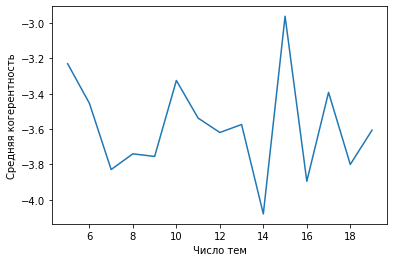

In [55]:
topics_list = np.arange(5,20)
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data['text_of_post'], dictionary=dictionary, coherence='u_mass').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

Максимальная когерентность достигается при 15 темах. Обучим соответствующую модель:

In [60]:
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, chunksize=50, update_every=1, passes=2)
x = lda.show_topics(num_topics=15, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: ждать программа друг билет квартира ребёнок парк школа детский выходной
topic_1: ребёнок это россия новый год который работать также мочь человек
topic_2: работа старый конкурс старорусский возможность скидка русс маршрут следующий рабочий
topic_3: магазин группа цена июнь товар стоимость https народный купить лицо
topic_4: новгородский область год рубль район россия водитель средство гражданин компания
topic_5: дом улица город александр петербург появиться район ремонт мост площадь
topic_6: чтo этo кaк мнe oнa тaк снег мeнить погода сын
topic_7: место руб подарок мир центр вместе декабрь самый девушка новый
topic_8: это всё год свой который ещё очень жизнь телефон весь
topic_9: мужчина внимание площадка война детский транспортный попасть зима вчера красный
topic_10: летний дорога который женщина человек дело автомобиль тверской полиция новгород
topic_11: https com наш месяц дверь неделя нужно ссылка качество пушкин
topic_12: великий новгород проект год регион новгородский гор

Теперь получилось по ощущениям чуть лучше. Некоторые темы вполне можно интерпретировать.

Например:

topic_0 - что то связанное с детским досугом и мероприятиями
topic_3 - что-то про торговлю, причем похоже именно на объявления о покупке и продаже чего-либо.

Но некоторые темы выглядят, как набор рандомных слов.

Также визуализируем темы:

In [61]:
%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 3.02 s, sys: 123 ms, total: 3.14 s
Wall time: 6 s


После уменьшения количества тем, на графике они выглядят теперь более разделимыми.

**Итоги:**
- Конечной цели - выделить мероприятия и достопримечательности - достичь не получилось.
- Получить набор хорошо интерпретируемых кластеров также не вышло.

**Что можно еще сделать:**
- В топах токенов, определяющих темы есть много мусора - местоимения, какие то общие слова и т.д.
- Нужно более внимательно исследовать словарь практически в ручном режиме и удалить оттуда лишние слова. Возможно, после этого удастся получить более осмысленные темы.